![MmSCel Logo](https://storage.googleapis.com/kaggle-competitions/kaggle/38128/logos/header.png?t=2022-08-08-22-48-50)


<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:250%;">
    <p style="padding: 4px;text-align: center;color:white;"><b>Complete EDA of MmSCel Integration Data</b></p>
    <p style="padding: 4px;text-align:center; color:white;"><b>Table of contents</b></p>
</div> 

1. [Intro](#1)
2. [What data is collected](#2)
    1. [Data from Multiome Test](#21)
        1. [Chromatin accessibility data](#211)
        2. [Gene Expression Data](#212)
    2. [Data from CITEseq test](#22)
        1. [Gene Expression Data](#221)
        2. [Surface Protein Level Data](#222)
3. [How is data collected](#3)
4. [Data centric view](#4)
    1. [Chromatin Accessibility](#41)
    2. [Gene Expression](#42)
        1. [From Multiome](#421)
        2. [From CITEseq](#422)
    3. [Surface Protein Levels](#43)
5. [How to Submit to competition](#5)

In [1]:
# sys and util
import os
import gc
import random
import re

# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# set data_dir
data_dir = os.environ['DATA_DIR']
sorted(os.listdir(data_dir))

['evaluation_ids.csv',
 'metadata.csv',
 'sample_submission.csv',
 'test_cite_inputs.h5',
 'test_cite_inputs_T.h5',
 'test_cite_inputs_T_feature_features.csv',
 'test_cite_inputs_cell_features.csv',
 'test_multi_inputs.h5',
 'test_multi_inputs_T.h5',
 'test_multi_inputs_T_feature_features.csv',
 'test_multi_inputs_cell_features.csv',
 'train_cite_inputs.h5',
 'train_cite_inputs_T.h5',
 'train_cite_inputs_T_feature_features.csv',
 'train_cite_inputs_cell_features.csv',
 'train_cite_targets.h5',
 'train_cite_targets_T.h5',
 'train_cite_targets_T_feature_features.csv',
 'train_cite_targets_cell_features.csv',
 'train_multi_inputs.h5',
 'train_multi_inputs_T.h5',
 'train_multi_inputs_T_feature_features.csv',
 'train_multi_inputs_cell_features.csv',
 'train_multi_targets.h5',
 'train_multi_targets_T.h5',
 'train_multi_targets_T_feature_features.csv',
 'train_multi_targets_cell_features.csv']

# 1 Intro <a id="1"></a>

The goal of this competition is to better understand the relationship between different modalities in cells. The goal of this notebook is to gain a better understanding of the associated data. This equips us with the knowledge needed to make good decisions about model design and data layout.

**This is a work in progress. If any aspect needs clarification, please let me know. My understanding of genetics is very limited. Feel free to point out anything that is false.**

During transcription in cells, there is a known **flow of information**. DNA must be accessible to produce RNA. Produced RNA is used as a template to build proteins. Therefore, one could assume that we can use knowledge about the accessibility of DNA to predict future states of RNA and that we can use knowledge about RNA to predict the concentration of proteins in the future. In this challenge, we want to learn more about this relationship between DNA, RNA, and proteins. We thus need to capture information about three distinct properties of a cell:
* chromatin accessibility (DNA)
* gene expression (RNA)
* surface protein levels

Before we have a look at how the information about those properties of a cell is laid out, we must note that the methods used to obtain the data do not capture all properties at once. **We have two distinct methods for testing**. The first one is the "10x Chromium Single Cell Multiome ATAC + Gene Expression" short "multiome" test. The second one is the "10x Genomics Single Cell Gene Expression with Feature Barcoding technology" short "citeseq" test.

With the multiome test, we can measure **chromatin accessibility and gene expression**. With the citeseq test, we can measure **gene expression and surface protein levels**. Therefore, we will have data about chromatin accessibility and surface protein levels once (from multiome and citeseq, respectively). And we will have data about gene expression two times, once from each test.

To get a better understanding of the data we will look at it from 3 perspectives. The first thing we will look at is, what data is actually collected. Questions we will adress here are: How many measurments do we get from each cell? How to interpret the measurements we have? How accurate is the data collected? This can be thought of as a biological view of the problem and is the main focus of **chapter two**. We will not go into details here how the general data landscape looks like.

The **third chapter** will look at how the data is collected. The focus of this chapter will be the metadata file. Questions of concern will be: On what days was the data collected? What different Splits do we obtain? How much data is in each split?

After having an understanding of the collection methods and results of the collection process we will have a look at the outcome of the collection. Namely the different datasets or splits, we are presented with. We will look at the properties of the splits as a whole and compute well known statistics about them. All of this can be found in **chapter four**.

This notebook will be concluded with the **final chapter** on necessary details to compete in the competition. We will have a look at what data needs to be submitted and in what format it has to be submitted.


# 2 What Data is collected <a id="2"></a>

Let's zoom in at what data is actually collected. As we already mentioned in the introduction we have two different test methods that each measure two modalities of the introspected cell. Therefore we have four measurments in total. Each of those four measurments receives its own subchapter. We will start witht the measurments from the multiome test and than look at the data from the citeseq test.

<a id="21"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>2.A Data from Multiome test</b></p>
</div> 

The first two measurments we are looking at are obtained by the multiome test. Multiome test is short for **Chromium Single Cell Multiome ATAC + Gene Expression**. As the name of the test suggest we get measurments for ATAC (assay for transpoase-accessible chromatin) and for Gene Expression Data. The tests are done by the Company 10x Genomics. The description of the test can be found [here](https://www.10xgenomics.com/products/single-cell-multiome-atac-plus-gene-expression). The test has a single cell resolution. That means every data point we obtain can be mapped to a single cell.

<a id="211"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:150%;">
    <p style="padding: 4px;color:white;"><b>2.A.a Chromatin accessibility data</b></p>
</div>

First we will have a look at the Chromatin Accessibility data, since that's also the first data in the information flow of a cell. Here we will just be concerened with a single data point and look at what data is measured. Below you see the ATAC data obtained by multiome for a single cell.

In [2]:
df_multi_train_x = pd.read_hdf(data_dir + '/train_multi_inputs.h5',start=0,stop=1)
df_multi_train_x

gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
56390cf1b95e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.428336,0.0,0.0,0.0,0.0


As we can see, each individual cell is identified by a cell_id in this case "56390cf1b95e". We then have 228942 measurments for each cell that are named something like "STUFF:NUMBER-NUMBER". STUFF is actually the name of a chromosome. Let's have a look at what kind of chromosomes we have:



In [3]:
print(sorted(list({i[:i.find(':')] for i in df_multi_train_x.columns})))

['GL000194.1', 'GL000195.1', 'GL000205.2', 'GL000218.1', 'GL000219.1', 'KI270711.1', 'KI270713.1', 'KI270721.1', 'KI270726.1', 'KI270727.1', 'KI270728.1', 'KI270731.1', 'KI270734.1', 'chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY']


We actually find the chromosomes we expect, namely chr1-chr22, the 22 chromosomes humans have (called autosomes), and also chrX and chrY, being the gender-specific chromosomes. What about the ones starting with KI and GL? According to a quick internet search, those are unplaced genes. They most likely are part of the human genome, but we don't know yet on which chromosome they are. 

What about the numbers after the chromosome name? These numbers identify a certain region on that chromosome. These regions are called peaks and multiple peaks can contribute to the same gene. For a nice and short introduction check out this [5 min Youtube Video on ATAC sequencing.](https://www.youtube.com/watch?v=uuxpyhGNDsk)

I want to look into three things in further detail:
* Why do we obtain numbers as floats? From what I understand so far, I would expect the data to be binary. Whether a peak is accessible or not.
* Can peak regions actually overlap? From the method explained in the video, I would assume not, but this needs to be checked.
* If multiple peaks contribute to a single gene, the assumption is obvious that if one peak is accessible, neighboring peaks are likely accessible as well. Is this the case?

<a id="212"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:150%;">
    <p style="padding: 4px;color:white;"><b>2.A.b Gene Expression Data</b></p>
</div>

The mere presence of a genome in a cell does not alter that cell or the organism that it is part of. The information in the genome must be "interpreted" in order for any change to take place. In other words, a gene's information is employed to create a functioning gene product. Either a protein or non-coding RNA might be this. The most fundamental method of converting genomic information into gene products is called gene expression. The information about the genes that are active in a particular cell or the regions of the genome that are involved in the function of the cell may be inferred from the gene expression data we are utilizing for this challenge. An example of that data for the cell 56390cf1b95e is provided below.

In [4]:
df_multi_train_y = pd.read_hdf(data_dir + '/train_multi_targets.h5', start=0, stop=1)

print(f"Different starts of names: {sorted(list({i[:10] for i in df_multi_train_y.columns}))}")
print(f"Different lengths of names: {len(df_multi_train_y.columns.str.len().unique())}")

df_multi_train_y

Different starts of names: ['ENSG000000', 'ENSG000001', 'ENSG000002']
Different lengths of names: 1


gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000256661,ENSG00000184389,ENSG00000128274,ENSG00000094914,ENSG00000081760,...,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
cell_id,,,,,,,,,,,,,,,,,,,,,
56390cf1b95e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.893861,0.0,0.0,0.0,0.0,5.583255,0.0,4.893861


As we can see, each ID begins with ENSG and is then followed by 5 zeroes. It is called Ensambl ID. The general form is ENS(species)(object type)(identifier).(version). ENS tells us that we are looking at an Ensembl ID. By convention, the species field for human genes is left blank. The object type for genes is G. The identifier appears to always be 11 decimal places long. Additionally, it appears that our data lacks any version specifications. 

I suggest viewing [this video](https://www.youtube.com/watch?v=bKIpDtJdK8Q) for a thorough explanation of the entire transcription and translation process we are exploring for this challenge. It provides a thorough summary of the role mRNA plays in the procedure. According to what I understand, each gene on the genome corresponds to an mRNA molecule, and the numbers in our dataset indicate how much mRNA for each corresponding gene is present in the sampled cell. More mRNA is indicated by higher values.

<a id="22"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>2.B Data from CITEseq test</b></p>
</div>

By now we have quite a good understanding of what data can be obtained by the multiome test. Now we want to have a look at the **Single Cell Gene Expression with Feature Barcoding technology**, or short **CITEseq** test. The test data we are provided with is again from the company 10x Genomics. Information about the test can be found on the company's website [here](https://support.10xgenomics.com/permalink/getting-started-single-cell-gene-expression-with-feature-barcoding-technology). It is a test to "reveal cell surface protein and gene expression from the same cell". Since we are already familiar with gene expression data, let's first look at that.

<a id="221"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:150%;">
    <p style="padding: 4px;color:white;"><b>2.B.a Gene Expression Data</b></p>
</div>

We are again loading a single sample from the test set to get an idea about the features we are presented with:

In [5]:
df_cite_train_x = pd.read_hdf(data_dir + '/train_cite_inputs.h5',start=0,stop=1)
df_cite_train_x

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.090185,0.0


The first thing we notice is that the start of the gene_id looks much like what we have seen in the multiome data, but there is a new suffix. So what is it about the suffix?

Checking the Ensembl ID of gene_id on [ensembl.org](https://www.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000121410;r=19:58345178-58353492) (in this case for ENSG00000121410) we see that the suffix is actually the name of the gene. As we will see in the next code cell, the gene_id is unique even without this suffix, so it looks like redundant information for now.

In [6]:
gene_ids_citeseq = set([i[:i.find("_")] for i in df_cite_train_x.columns])
len(gene_ids_citeseq)

22050

Stripping of the suffixes still produces 22050 unique ids.

Let's check for overlap in both datasets about gene expression:

In [7]:
gene_ids_multiome = set(df_multi_train_y.columns)

print(f"Elements in Set Union: {len(gene_ids_citeseq | gene_ids_multiome)}")
print(f"Elements in Set Intersection: {len(gene_ids_citeseq & gene_ids_multiome)}")
print(f"multiome has {len(gene_ids_multiome - gene_ids_citeseq)} unique gene ids.")
print(f"Citeseq has {len(gene_ids_citeseq - gene_ids_multiome)} unique gene ids.")

Elements in Set Union: 27082
Elements in Set Intersection: 18386
multiome has 5032 unique gene ids.
Citeseq has 3664 unique gene ids.


We have quite a huge overlap. More than 18k genes are found in both datasets. But still there are quite a few genes that are unique in each dataset.

<a id="222"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:150%;">
    <p style="padding: 4px;color:white;"><b>2.B.b Surface protein level data</b></p>
</div>

Lastly, we will have a look at the surface protein levels data gathered by citeseq.

In [8]:
df_cite_train_y = pd.read_hdf(data_dir + '/train_cite_targets.h5', start=0, stop=1)
df_cite_train_y

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.62253,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.44839,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.54807


Compared to what we have seen so far, the number of columns in this data set is quite small. We have measurements of 140 features per cell. Most of the names start with CD, which is short for "Cluster of differentiation". CDs are used to classify surface molecules a cell expresses. This information can then be used to get an idea of what kind of cell is present, or what function this cell is supposed to serve in the body (I am not sure if my understanding here is even remotely accurate).

Here we see all the measured proteins that do not start with CD:

In [9]:
surface_portein_ids = set(df_cite_train_y.columns)
regex = re.compile(r'^CD.*')
{p for p in surface_portein_ids if not regex.match(p)}

{'CX3CR1',
 'FceRIa',
 'HLA-A-B-C',
 'HLA-DR',
 'HLA-E',
 'IgD',
 'IgM',
 'KLRG1',
 'LOX-1',
 'Mouse-IgG1',
 'Mouse-IgG2a',
 'Mouse-IgG2b',
 'Podoplanin',
 'Rat-IgG1',
 'Rat-IgG2a',
 'Rat-IgG2b',
 'TCR',
 'TCRVa7.2',
 'TCRVd2',
 'TIGIT',
 'integrinB7'}

Iterestingly some of the names start with Rat or Mouse. All of our donors are humans. We will later see if we actually find non zero values for these proteins in the test set.

Now having a rough understanding what data is collected by each test and how to interpret the collected data we will have a look at how data is collected. This will be the main focus of chapter 3.

# 3 How is data collected <a id="3"></a>

On top of the actual data we have information about how the data is collected. This metadata is stored in the file metadata.csv. The file contains one row for each cell in the dataset and provides some additional information about that cell.

In [10]:
df_meta = pd.read_csv(data_dir + '/metadata.csv').set_index("cell_id")
df_meta

,day,donor,cell_type,technology
cell_id,,,,
c2150f55becb,2,27678,HSC,citeseq
65b7edf8a4da,2,27678,HSC,citeseq
c1b26cb1057b,2,27678,EryP,citeseq
917168fa6f83,2,27678,NeuP,citeseq
2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...
96a60b026659,10,31800,hidden,multiome
d493e546991e,10,31800,hidden,multiome
05666c99aa48,10,31800,hidden,multiome


For each cell, we see the **day** column tells us on which day the test was performed. The test that was actually performed is shown in the **technology** column. Note that experiments started on day 1, therefore the first tests were performed one day after the cells were injected with Neupogen for the first time ([compare here](https://allcells.com/research-grade-tissue-products/mobilized-leukopak/)). For each of the four donors, we have a **donor** ID giving us information about the origin of the cell. Lastly, there is a **cell_type** column. The cell types are labels assigned by humans. They might be imprecise and this information is not available for test data since it would be possible to draw conclusions about surface protein levels, for example. It is not clear if we can make use of that later (maybe we can use it for creating balanced splits, but we will see).

[jirkaborovec](https://www.kaggle.com/jirkaborovec) already composed a great analysis of the metadata in this [notebook](https://www.kaggle.com/code/jirkaborovec/mmscel-inst-eda-stat-predictions). I will copy some parts here for readability and add some comments myself.

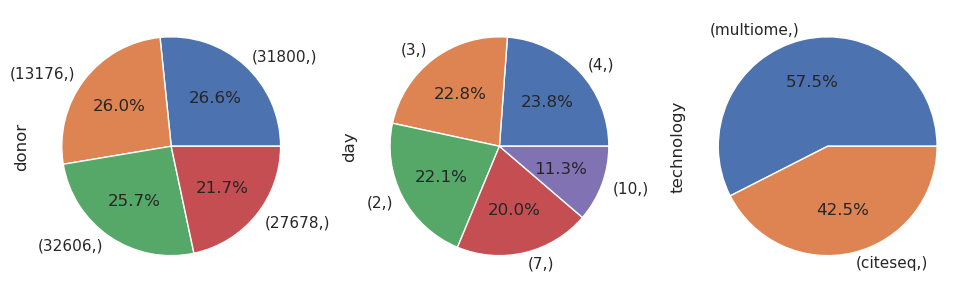

In [11]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
for i, col in enumerate(["donor", "day", "technology"]):
    _= df_meta[[col]].value_counts().plot.pie(ax=axarr[i], autopct='%1.1f%%', ylabel=col)

As we can see, the cell data is pretty balanced. We have almost an equal number of cells from each donor (the big numbers in the first picture are the donor ids). Also, the days of the experiment were fairly balanced. The last day, day 10, only receives an 11% share of the cells. Day 10 is also the only day not present in the train data at all! Also, the train set does not contain any data from donor 27678!

We have slightly more data available for the multinome test. It is not the worst since our model also has to predict many more features for that test.

The distribution of data in general is pretty well balanced (e. g., the number of tests taken / test / day is well distributed). For a more in-depth analysis of the metadata, I highly recommend the already mentioned [notebook](https://www.kaggle.com/code/jirkaborovec/mmscel-inst-eda-stat-predictions).

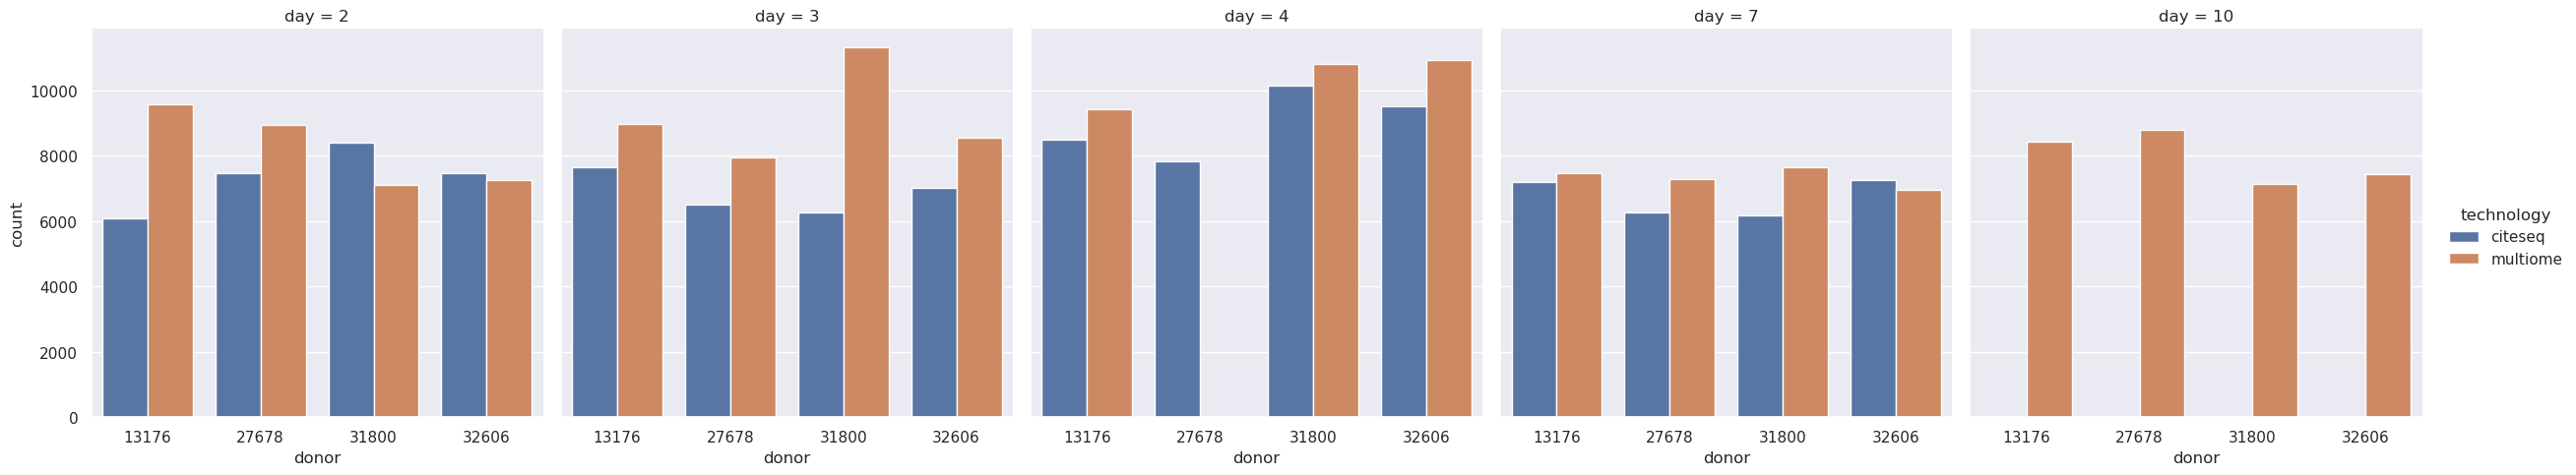

In [12]:
sns.catplot(
    data=df_meta,
    x="donor",
    hue="technology",
    col="day",
    kind="count",
)

# 4 Data centric view <a id="4"></a>

Having a good understanding about what properties of a cell we measure and how data is collected lets now look at the properties of the datasets we are provided with. The following three subchapters will focus on that. One Subchapter for each property.

<a id="41"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>4.A Chromatin Accessibility</b></p>
</div>

This part of the analysis is actually quite challenging. The problem we face is due to layout of memory. We receive the memory arranged by rows. This means, for a single cell all the features about that cell are arranged together in memory. But in some cases we are interested in properties of features and not properties of cells. To give an example, it would be really interesting to know the mean and std deviation of every feature present in our dataset. Since we cannot load the whole dataset into memory at once, we have to load batches. The problem is, that when loading say 10 feature columns, we have to look at (cell count) different locations in storage. This takes considerable time, since we have about 100k cells. If we wanted to load the features of 10 cells into RAM we would get results almost immediately. 

Therefore I created a dataset with the data transposed (its uploaded on kaggle as mmscel-data-transposed). And also two notebooks that calculate features of rows and columns. They are named "cell-feature-generation" and "feature-feature-generation". Both are public as well.

Let's start with looking at "cell features". This is the easier part of the analysis.

In [13]:
# lets load the calculated features into a dataframe
# eigentlich koennen wir hier alle cell feature csv auf einmal laden und die df zusammenhaengen
df_train = pd.read_csv(data_dir + '/train_multi_inputs_cell_features.csv').rename(columns={'Unnamed: 0': 'cell_id'})
df_train.insert(1, 'set', 'train')
df_test = pd.read_csv(data_dir + '/test_multi_inputs_cell_features.csv').rename(columns={'Unnamed: 0': 'cell_id'})
df_test.insert(1, 'set', 'test')

df = pd.concat([df_train, df_test]).reset_index(drop=True)
del df_train, df_test; gc.collect()

df

,cell_id,set,count_non_zero,max_value,min_value,sum_values,mean_non_zero,1_tups,2_tups,3_tups,...,7_tups,8_tups,9_tups,10_tups,11_tups,12_tups,13_tups,14_tups,15_tups,16_tups
0,56390cf1b95e,train,5276,8.659626,0.0,14317.626953,2.713728,4895,181,5,...,0,0,0,0,0,0,0,0,0,0
1,fc0c60183c33,train,2733,9.421093,0.0,9253.330078,3.385777,2607,63,0,...,0,0,0,0,0,0,0,0,0,0
2,9b4a87e22ad0,train,4799,8.052182,0.0,13642.458984,2.842771,4489,149,4,...,0,0,0,0,0,0,0,0,0,0
3,81cccad8cd81,train,5059,7.973050,0.0,13687.925781,2.705658,4748,145,7,...,0,0,0,0,0,0,0,0,0,0
4,15cb3d85c232,train,4541,8.083150,0.0,12941.090820,2.849833,4284,127,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161872,96a60b026659,test,1708,12.805870,0.0,6022.281738,3.525926,1637,34,1,...,0,0,0,0,0,0,0,0,0,0
161873,d493e546991e,test,8907,7.159112,0.0,12696.928711,1.425500,7816,489,35,...,0,0,0,0,0,0,0,0,0,0
161874,05666c99aa48,test,9630,5.528481,0.0,13069.636719,1.357179,8375,558,42,...,0,0,0,0,0,0,0,0,0,0
161875,121f946642b5,test,23478,3.302262,0.0,16276.682617,0.693274,17040,2411,381,...,1,0,0,0,0,0,0,0,0,0


In [14]:
print(f"Each cell has at least {df['count_non_zero'].min()} genes with non-zero accessibility values and a maximum of {df['count_non_zero'].max()}.")
print(f"On average there are {round(df['count_non_zero'].mean())} genes with non-zero accessibility values in each cell.")
print(f"The mean non-zero value for each cell ranges between {df['mean_non_zero'].min()} and {df['mean_non_zero'].max()}.\nThe average mean non-zero over all cells is {df['mean_non_zero'].mean()}.")

Each cell has at least 746 genes with non-zero accessibility values and a maximum of 35837.
On average there are 5936 genes with non-zero accessibility values in each cell.
The mean non-zero value for each cell ranges between 0.4725135862827301 and 6.876746654510498.
The average mean non-zero over all cells is 2.4689990657683927.


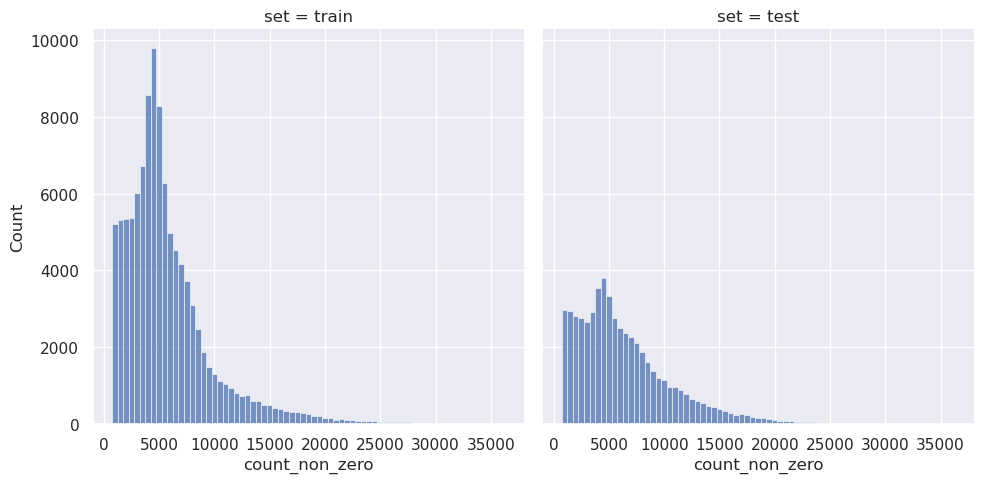

In [15]:
sns.displot(df, x="count_non_zero", binwidth=500, col='set')
# hier evtl kind=kde irgendwo verwenden (weil die hoehen sonst unterschiedlich sind wegen der verschiedenen set groessen)

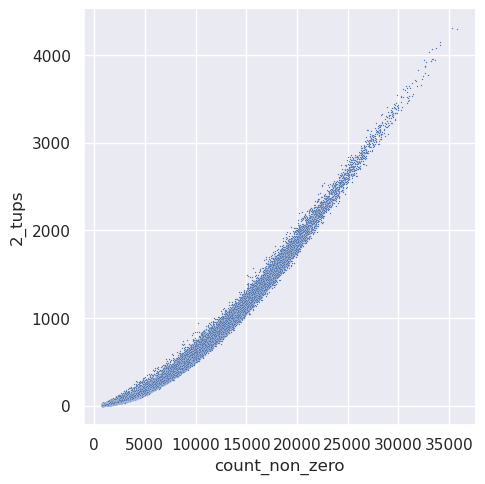

In [16]:
sns.relplot(
    data=df,
    x='count_non_zero', y='2_tups', s=1
)

Next we will see something really interesting. As mentioned before the locations on the genome we are looking at are called peeks. Multiple peeks can constitute to a single gene. Therefore one can assume, that we find groups of neighbooring peeks, that are all non-zero (the logic behind that is, that reading DNA cares about reading a whole gene and not about reading human defined peek regions). So lets check for that. We will take 100 random samples from the test set.

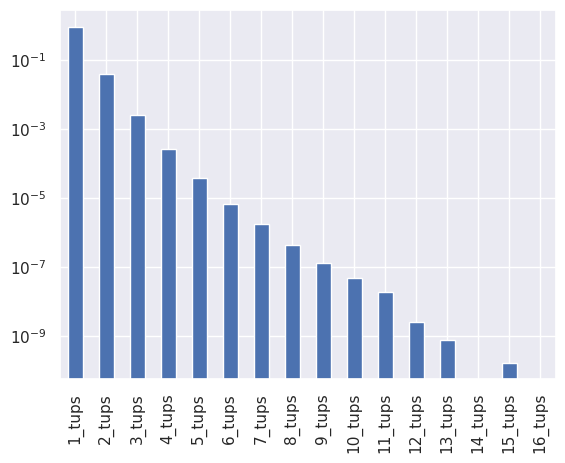

In [17]:
tups_cols = df.columns[7:23]
df_tups = df[tups_cols].div(df['count_non_zero'], axis='index').mean(axis=0).plot.bar().set_yscale('log')

This is definitely not what I expected. Most of the accessible parts of the genome do not have any accessible neighbors. As I am not a geneticist I don't know why this is the case. Maybe someone else can explain.

After having a look at "features of cells" we will have a look at "features of features". 
Here we can take advantage of our prepared data as well.

In [18]:
df_train = pd.read_csv(data_dir + '/train_multi_inputs_T_feature_features.csv').rename(columns={'Unnamed: 0': 'peek_location'})
df_train.insert(1, 'set', 'train')
df_test = pd.read_csv(data_dir + '/test_multi_inputs_T_feature_features.csv').rename(columns={'Unnamed: 0': 'peek_location'})
df_test.insert(1, 'set', 'test')

df = pd.concat([df_train, df_test]).reset_index(drop=True)
del df_train, df_test; gc.collect()

df

,peek_location,set,count_non_zero,max_value,min_value,sum_values,mean_non_zero,1_tups,2_tups,3_tups,...,7_tups,8_tups,9_tups,10_tups,11_tups,12_tups,13_tups,14_tups,15_tups,16_tups
0,GL000194.1:114519-115365,train,1133,10.165502,0.0,3498.784668,3.088071,1097,18,0,...,0,0,0,0,0,0,0,0,0,0
1,GL000194.1:55758-56597,train,1022,11.767000,0.0,3473.189941,3.398425,986,18,0,...,0,0,0,0,0,0,0,0,0,0
2,GL000194.1:58217-58957,train,193,9.639187,0.0,745.563354,3.863023,193,0,0,...,0,0,0,0,0,0,0,0,0,0
3,GL000194.1:59535-60431,train,305,13.753135,0.0,1243.379395,4.076654,303,1,0,...,0,0,0,0,0,0,0,0,0,0
4,GL000195.1:119766-120427,train,695,12.015840,0.0,2585.378906,3.719970,682,5,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457879,chrY:7814107-7815018,test,0,0.000000,0.0,0.000000,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
457880,chrY:7818751-7819626,test,0,0.000000,0.0,0.000000,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
457881,chrY:7836768-7837671,test,0,0.000000,0.0,0.000000,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
457882,chrY:7869454-7870371,test,0,0.000000,0.0,0.000000,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# check for peeks that are zero for every single cell
df[(df['count_non_zero'] == 0)].head(15)

,peek_location,set,count_non_zero,max_value,min_value,sum_values,mean_non_zero,1_tups,2_tups,3_tups,...,7_tups,8_tups,9_tups,10_tups,11_tups,12_tups,13_tups,14_tups,15_tups,16_tups
5604,chr10:41857982-41858833,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5608,chr10:41879051-41879911,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15011,chr11:1946784-1947675,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37770,chr13:65965314-65966055,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111705,chr21:21146641-21147535,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124620,chr2:174378385-174378803,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128976,chr2:229971085-229972015,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128977,chr2:229973874-229974716,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128978,chr2:229980590-229981447,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128979,chr2:230008001-230008814,train,0,0.0,0.0,0.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see, there are 10 peek region, that are zero for every single cell. We can remove those features from our dataset.

In [20]:
print(f"Values range from {df['min_value'].min()} to {df['max_value'].max()}")


Values range from 0.0 to 18.601043701171875


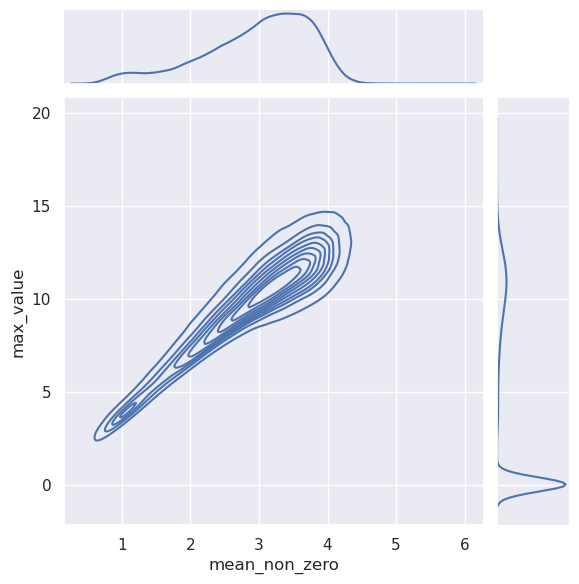

In [21]:
sns.jointplot(
    data=df,
    x="mean_non_zero", y="max_value",
    kind="kde"
)

<AxesSubplot:ylabel='Density'>

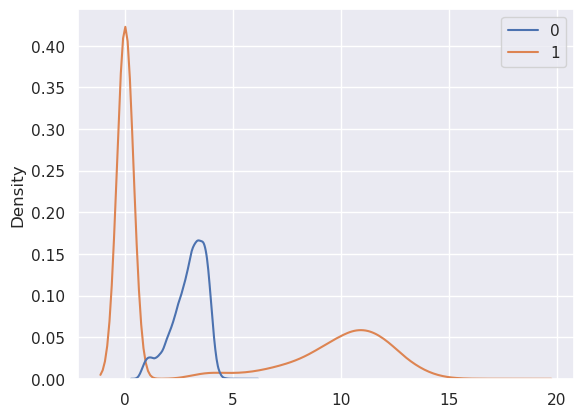

In [22]:
sns.kdeplot(data=df[['mean_non_zero', 'max_value']].values)

<a id="42"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>4.B Gene Expression</b></p>
</div>

<a id="221"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:150%;">
    <p style="padding: 4px;color:white;"><b>4.B.a From Multiome</b></p>
</div>

<a id="221"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:150%;">
    <p style="padding: 4px;color:white;"><b>4.B.b From CITEseq</b></p>
</div>

<a id="43"></a><div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>4.C Surface Protein Levels</b></p>
</div>

# 5 How to submit to competition <a id="5"></a>

# X Notes

There are still some open questions in the text we need to address. 

* Correct Information about peaks in chromatin accessibility data
* include memory information for each data frame
* review ordering (single cell view, (metadata), data science centric view, kaggle specific data)
* Add Data overview (size of Datasets)